In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


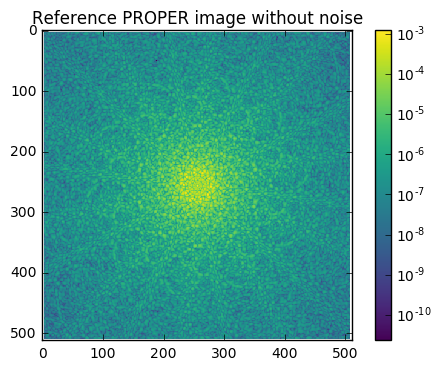

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

18776460.3635


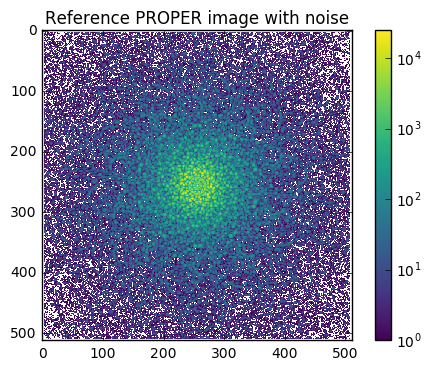

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fit by tweaking position


In [8]:
# Function to generate 
errors = []
def model_err(pos, view=False):
    tiltx = pos[0]
    tilty = pos[1]
    settings = toliman_settings.copy()
    settings['tilt_x'] = tiltx 
    settings['tilt_y'] = tilty
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - detector_image)**2)
    errors.append((pos,error))
    print('Error for offset ({},{}): {} '.format(tiltx, tiltx, error))
    return error

## Sanity check

How does error value vary over reasonable range? 

In [9]:
errors = []
for dx in [-0.5, -0.25, 0, 0.25, 0.5]:
    for dy in [-0.5, -0.25, 0, 0.25, 0.5]:
        model_err([dx,dy], view=False)

Error for offset (-0.5,-0.5): 78195499518.38985 
Error for offset (-0.5,-0.5): 81724863469.05023 
Error for offset (-0.5,-0.5): 83288632383.68242 
Error for offset (-0.5,-0.5): 81579313288.15862 
Error for offset (-0.5,-0.5): 78786863166.38696 
Error for offset (-0.25,-0.25): 81751622544.68643 
Error for offset (-0.25,-0.25): 74880739484.66315 
Error for offset (-0.25,-0.25): 52085038452.59397 
Error for offset (-0.25,-0.25): 74897114645.69545 
Error for offset (-0.25,-0.25): 81560904645.66318 
Error for offset (0,0): 83276842625.14668 
Error for offset (0,0): 52112860728.0963 
Error for offset (0,0): 18776460.363505144 
Error for offset (0,0): 52145498461.775314 
Error for offset (0,0): 83308040338.53363 
Error for offset (0.25,0.25): 81528867327.06598 
Error for offset (0.25,0.25): 74888827038.24094 
Error for offset (0.25,0.25): 52118640398.29744 
Error for offset (0.25,0.25): 74858994116.46661 
Error for offset (0.25,0.25): 81717988551.97295 
Error for offset (0.5,0.5): 78791307346

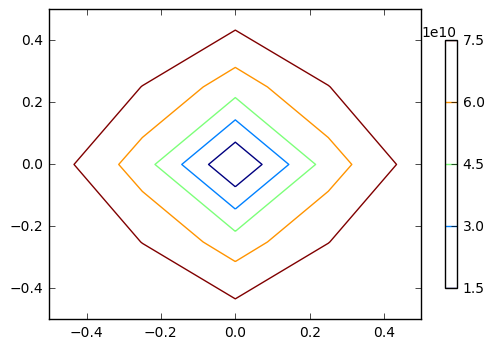

In [10]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid([-0.5, -0.25, 0, 0.25, 0.5],[-0.5, -0.25, 0, 0.25, 0.5])
plt.figure()
Z = np.reshape([e for ((dx,dy),e) in errors],(5,5), order='F')
CS = plt.contour(X, Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

## Optimize

### Nelder-Mead Simplex algorithm

This is a popular derivative-free multivariate minimization algorithm.

In [11]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.01, 0.01]
opt = minimize(model_err, dir_init, method='nelder-mead')

Error for offset (0.01,0.01): 255750561.87425607 
Error for offset (0.0105,0.0105): 267835584.8307086 
Error for offset (0.01,0.01): 267824712.05979186 
Error for offset (0.0095,0.0095): 256327045.1306396 
Error for offset (0.0095,0.0095): 244251234.71371928 
Error for offset (0.009249999999999998,0.009249999999999998): 232902774.3157103 
Error for offset (0.009749999999999997,0.009749999999999997): 232914264.82262602 
Error for offset (0.008999999999999996,0.008999999999999996): 210941885.33143297 
Error for offset (0.008499999999999994,0.008499999999999994): 190292162.26912445 
Error for offset (0.007999999999999995,0.007999999999999995): 190867776.0706419 
Error for offset (0.007249999999999989,0.007249999999999989): 152645891.11124244 
Error for offset (0.006249999999999985,0.006249999999999985): 119546576.31312607 
Error for offset (0.0067499999999999834,0.0067499999999999834): 119560529.79386814 
Error for offset (0.0044999999999999745,0.0044999999999999745): 67289154.78070475 
E

In [12]:
print(opt)

 final_simplex: (array([[ -4.95725231e-05,  -3.32188967e-05],
       [ -4.95834054e-05,  -3.32108914e-05],
       [ -4.95728795e-05,  -3.32079369e-05]]), array([ 18772271.04361224,  18772271.0436247 ,  18772271.04365484]))
           fun: 18772271.043612242
       message: 'Optimization terminated successfully.'
          nfev: 95
           nit: 53
        status: 0
       success: True
             x: array([ -4.95725231e-05,  -3.32188967e-05])


In [13]:
# How do things look now?
tiltx = opt.x[0]
tilty = opt.x[1]
settings = toliman_settings.copy()
settings['tilt_x'] = tiltx 
settings['tilt_y'] = tilty
source = {
        'wavelengths': [wavelength],
        'weights': [1.],
        'settings': settings
        }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

In [14]:
final *= intensity_scale

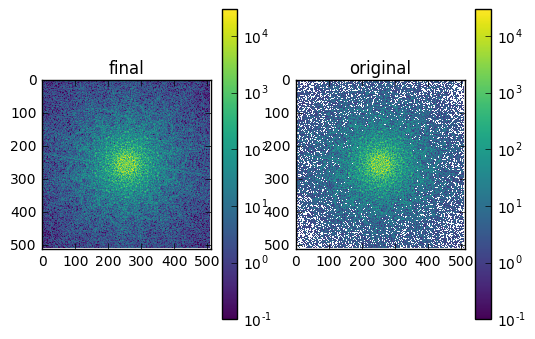

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [16]:
print("Final error {:.2e} vs. minimum bound of {:.2e}".format(np.sum((detector_image - final)**2), min_err))

Final error 1.88e+07 vs. minimum bound of 1.88e+07


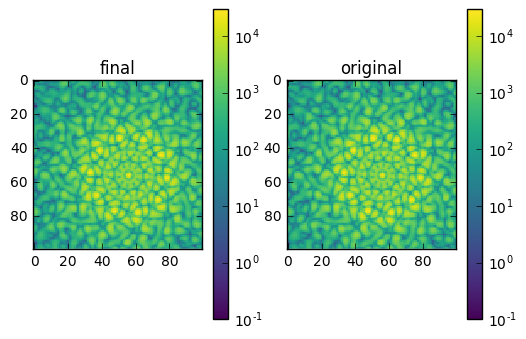

In [17]:
# zoom into central region
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

-0.00575 0.0105 -0.0055 0.0105


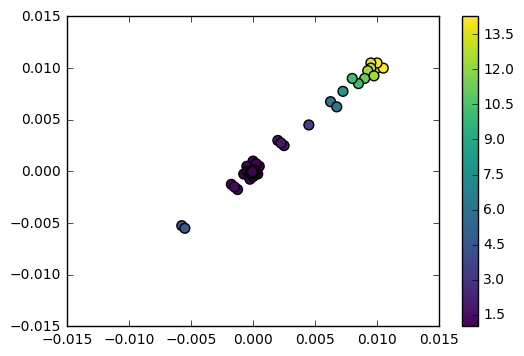

In [18]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt

(X,Y,E) = zip(*[(dx,dy,e) for ((dx,dy),e) in errors])

#color = [str(item/255.) for item in y]
print(np.min(X),np.max(X),np.min(Y),np.max(Y))
plt.scatter(X, Y, s=50, c=[e/min_err for e in E], cmap='viridis' )
plt.xlim(-0.015,0.015)
plt.ylim(-0.015,0.015)
plt.colorbar()
plt.show()